# Generating 4 classes

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2
import PIL.Image
import torch
import legacy
import dnnlib
import numpy as np
import tqdm.notebook as tqdm
import imageio
import shutil
import os
from PIL import Image
import gradio as gr
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Path to the trained model
model_path="models/oct.pkl"

# Directory where temporary files should be stored
directory = "demo"

# Available classes to choose from
classes = ["NORMAL", "CNV", "DRUSEN", "DME"]
classes_dict = {"NORMAL": 0, "CNV": 1, "DRUSEN": 2, "DME": 3}

# Torch device
device = torch.device('cuda')

# Generate an image

In [ ]:
# Method to generate an image by choosing out of four classes 
def generate_noise_image(choice):
    random_seed = np.random.randint(1, 9999)
    execution = f"python3 generate.py --outdir={directory} --seeds={random_seed} --network={model_path} --class={classes_dict[choice]}"
    os.system(execution)    
    img = Image.open(f"{directory}/seed{str(random_seed).zfill(4)}.png")
    return img

iface1 = gr.Interface(
    fn=generate_noise_image,
    inputs=gr.inputs.Dropdown(choices=["NORMAL", "CNV", "DRUSEN", "DME"], default="NORMAL", label="Class"),
    outputs=gr.outputs.Image(type="pil").style(height=256, width=256)
)

# Interpolating between x images

In [ ]:
# Method to create a video of an interpolation between x images
def generate_noise_image(sequence, frames, n_steps):
    try:
        shutil.rmtree(directory)
    except OSError as error:
        print(f"Failed to delete directory '{directory}': {error}")
    
    counts = [sequence.count(str(i)) for i in range(4)]
    random_seeds = np.sort(np.random.randint(1, 9999, sum(counts)))
    random_seeds = [3577, 5136, 6950]
    print(counts)
    print(random_seeds)
    lvecs = []
    
    for i in range(sum(counts)):
        execution = f"python3 generate.py --outdir={directory} --seeds={random_seeds[i]} --network={model_path} --class={sequence[i]}"
        os.system(execution)
        
        execution = f"python3 projector.py --outdir={directory}/projections/{str(i).zfill(2)} --target={directory}/seed{str(random_seeds[i]).zfill(4)}.png --network={model_path} --num-steps={int(n_steps)} --save-video=True"
        os.system(execution)
        
        lvecs.append(np.load(f'{directory}/projections/{str(i).zfill(2)}/projected_w.npz')['w'])

    FPS = 60
    FREEZE_STEPS = 30
    STEPS = int(frames)
    
    with dnnlib.util.open_url(model_path) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)  # type: ignore
    
    video = imageio.get_writer(f'{directory}/video.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

    for i in range(sum(counts) - 1):
        diff = lvecs[i+1] - lvecs[i]
        step = diff / STEPS
        current = lvecs[i].copy()
        target_uint8 = np.array([256, 256, 3], dtype=np.uint8)


        for j in range(STEPS):
            z = torch.from_numpy(current).to(device)
            synth_image = G.synthesis(z, noise_mode='const')
            synth_image = (synth_image + 1) * (255 / 2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

            repeat = FREEZE_STEPS if j == 0 or j == (STEPS - 1) else 1

            for i in range(repeat):
                video.append_data(synth_image)
            current = current + step

    video.close()
    
    return f"{directory}/video.mp4"

sequence = gr.inputs.Textbox(default="13", label="Sequence input")
n_steps = gr.inputs.Number(default=100, label="Latent Steps")
frames = gr.inputs.Number(default=240, label="Frames")
output = gr.outputs.Video(type="mp4").style(height=256, width=256)

iface3 = gr.Interface(
    fn=generate_noise_image,
    inputs=[sequence, frames, n_steps],
    outputs=output,
    description="This Gradio interface generates a video by morphing in the latent space between given class images. To use it, enter a string consisting only of letters from 0-3 to serve as class labels."
)

# Multiple Tabs

In [ ]:
gr.TabbedInterface(
    [iface1, iface3], ["Generate an image", "Generate a video"]
).launch(share=True)

# Load a latent representation as image

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


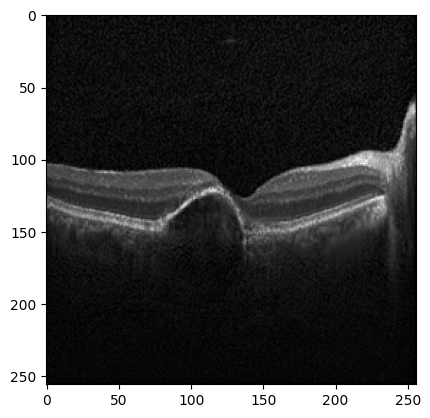

In [3]:
with dnnlib.util.open_url(model_path) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

vec = np.load(f'{directory}/projections/00/projected_w.npz')['w']

current = vec.copy()

z = torch.from_numpy(current).to(device)
synth_image = G.synthesis(z, noise_mode='const')
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

plt.imshow(synth_image, cmap='gray')
plt.show()